# 重力数据处理
### 计算重力异常

实测重力值受观测高度，地面起伏等影响，在实际应用时往往需要扣除这些相关因素。
<div  align="center">  
<img src="figures/normal_gravity.png" width = "500"/>
</div>

/home/pi/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


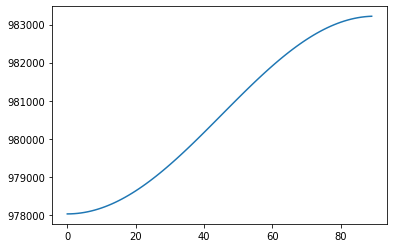

In [1]:
from geoist.pfm import normgra 
import geoist
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
lat = 45.0
height = 1000.0 
height1 = 5000.0
grav = 976783.05562266 #mGal 重力观测数据

# 正常重力随纬度的变化
grav_normal = np.empty(90)
x =  range(0, 90, 1)
for i in range(0, 90, 1):
    grav_normal[i] = normgra.gamma_closed_form(i, 0)
plt.plot(x, grav_normal)
plt.show()

In [4]:
# 获取正常重力场(经高度校正)
gamma = normgra.gamma_closed_form(lat, height)
print("lat=45, height=1000m:", gamma)

gamma1 = normgra.gamma_closed_form(lat, height1)
print("lat=45, height=5000m:", gamma1)

lat=45, height=1000m: 980311.2896926827
lat=45, height=5000m: 979078.7898348342


#### 坐标系统选择
#### gamma1 = normgra.gamma_closed_form(lat, height, ellipsoid = GRS80) 

In [5]:
# 另一种获取布格重力异常的方法
somi = normgra.gamma_somigliana_free_air(lat, height) 
print(somi)
#somi1 = normgra.gamma_somigliana_free_air(lat, height, ellipsoid = GRS80) 
bug = normgra.bouguer_plate(height)  #计算布格板产生的重力异常
print(bug)

980311.1769377294
111.94694713134103


In [6]:
bouguer = grav -gamma - bug
print("布格重力异常为：", bouguer)

布格重力异常为： -3640.181017154048


# 重力数据处理之坐标投影
实际陆地重力数据处理过程，首先是对每个测量点进行重力异常计算。计算好每个点上的重力异常后，要看重力异常场的特征或者进一步进行空间导数和延拓等变换。都需要基于网格化的数据来进行，这时候最常用的就是网格化。

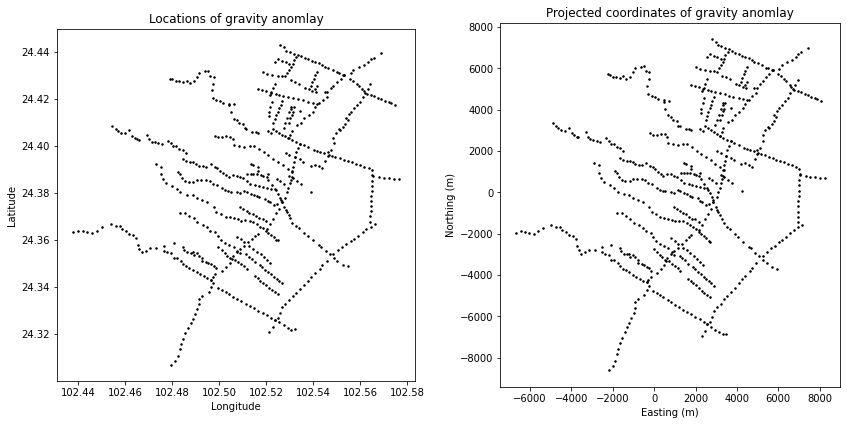

In [7]:
from pathlib import Path 
from geoist.pfm import normgra 
from geoist import DATA_PATH 
import pyproj
datapath = Path(Path(normgra.__file__).parent, 'data') 
filename = Path(datapath, 'ynyx_grav.csv')
gradata = pd.read_csv(filename) 

p_jw = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs" 
p_lcc = "+proj=lcc +lon_0=102.5 +lat_0=24.38 +lat_1=45 +ellps=WGS84 +datum=WGS84 +no_defs" 
proj_xy = pyproj.Proj(p_lcc) #projection = pyproj.Proj(proj="merc", lat_ts=gradata['lat'].mean())
proj_coords = proj_xy(gradata['lon'].values, gradata['lat'].values)
gradata['x'] = proj_coords[0] 
gradata['y'] = proj_coords[1] 
proj_jw = pyproj.Proj(p_jw) 

origin_lon, origin_lat = pyproj.transform(proj_xy, proj_jw, gradata['x'].values, gradata['y'].values) 
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(12,6)) 
ax0.set_title("Locations of gravity anomlay") 
ax0.plot(gradata['lon'], gradata['lat'], "ok", markersize=1.5) 
ax0.set_xlabel("Longitude") 
ax0.set_ylabel("Latitude") 
ax0.set_aspect("equal") 
ax1.set_title("Projected coordinates of gravity anomlay") 
ax1.plot(gradata['x'], gradata['y'], "ok", markersize=1.5) 
ax1.set_xlabel("Easting (m)") 
ax1.set_ylabel("Northing (m)") 
ax1.set_aspect("equal") 
plt.tight_layout()
plt.show()

### 网格化
离散点网格化，需要使用到GEOIST的gridder模块，里面有两个类需要导入，分别为：spline，mask。直接看代码吧！

In [8]:
from geoist.gridder import spline, mask
#计算重力异常
gradata['freeair'] = normgra.gamma_closed_form(gradata['lat'], gradata['elev']) 
gradata['buglayer'] = normgra.bouguer_plate(gradata['elev']) 
gradata['FGA'] = gradata['grav'] - gradata['freeair'] 
gradata['BGA_s'] = (gradata['grav'] - gradata['freeair'] - gradata['buglayer']).astype(np.float32)


/home/pi/.local/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


网格化信息如下： <xarray.Dataset>
Dimensions:   (northing: 81, easting: 76)
Coordinates:
  * easting   (easting) float64 -6.697e+03 -6.497e+03 ... 8.054e+03 8.253e+03
  * northing  (northing) float64 -8.602e+03 -8.402e+03 ... 7.192e+03 7.392e+03
Data variables:
    BGAs      (northing, easting) float64 -73.19 -73.8 -74.39 ... -92.56 -92.38
Attributes:
    metadata:  Generated by Spline(force_coords=(array([-2232.39953663, -2132...


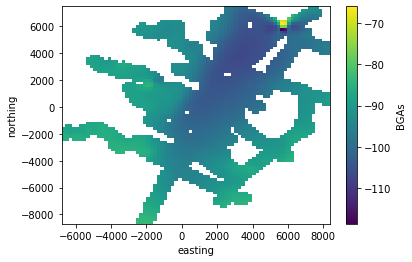

In [9]:
gradata = gradata.astype("float32")
BGA = spline.Spline().fit(proj_coords, gradata['BGA_s'])
res_BGA = gradata['BGA_s'].values - BGA.predict(proj_coords) 
grid = BGA.grid(spacing=2e2, data_names=["BGAs"]) 
print('网格化信息如下：',grid) 
type(grid) 
grid1 = mask.distance_mask(proj_coords, maxdist=5e2, grid=grid) 
grid1.BGAs.plot.pcolormesh()

### 去趋势

/home/pi/.local/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/home/pi/.local/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/home/pi/.local/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2

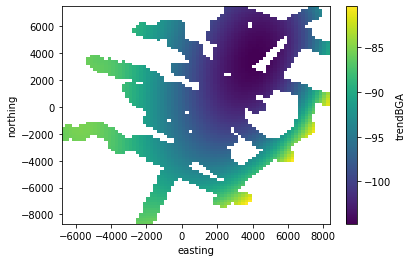

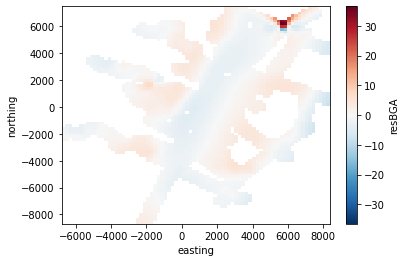

In [20]:
gradata['freeair'] = normgra.gamma_closed_form(gradata['lat'], gradata['elev']) 
gradata['buglayer'] = normgra.bouguer_plate(gradata['elev']) 
gradata['FGA'] = gradata['grav'] - gradata['freeair'] 
gradata['BGA_s'] = gradata['grav'] - gradata['freeair'] - gradata['buglayer']

from geoist.gridder import trend 
trend = trend.Trend(degree = 3).fit(proj_coords, gradata['BGA_s'].values) 
#print('4. 拟合的趋势系数：'.format(trend.coef_)) 
trend_values = trend.predict(proj_coords) 
residuals = gradata['BGA_s'].values - trend_values 

# 绘制趋势项
trendBGA = spline.Spline().fit(proj_coords, trend_values) 
grid2_trend = trendBGA.grid(spacing=2e2, data_names=["trendBGA"]) 
grid3_trend = mask.distance_mask(proj_coords, maxdist=5e2, grid=grid2_trend) 
plt.figure() 
grid3_trend.trendBGA.plot.pcolormesh()
# 绘制残差
resBGA = spline.Spline().fit(proj_coords, residuals) 
grid2 = resBGA.grid(spacing=2e2, data_names=["resBGA"]) 
grid3 = mask.distance_mask(proj_coords, maxdist=5e2, grid=grid2) 
plt.figure() 
grid3.resBGA.plot.pcolormesh()

### 位场的解析延拓
位场的延拓需要使用pftrans模块下的upcontinue函数，其中有两个参数需要设定，一个是shape，另一个是height。height单位为m，向上为正。  这些需要注意的是，upcontinue函数需要输入的位场数据格式为x,y,z形式，这三个都必须是1-d array。

In [21]:
from geoist.pfm import pftrans 
from geoist.vis import giplt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Proj
#数据取自WGM2012模型
data = pd.read_csv("data/ex_bouguer.csv")

In [22]:
lat = np.array(data["LAT"])
lon = np.array(data["LON"])
p2 = Proj(proj='tmerc', lon_0=np.min(lon), lat_0=np.min(lat),  preserve_units=False)
X,Y = p2(lon, lat)
gravity_origin = np.array(data["GRAVITY"])
#数据网格大小
shape = (121,121)
height = 5000
bgas_contf = pftrans.upcontinue(X, Y, gravity_origin, shape, height)

/home/pi/.local/lib/python3.7/site-packages/geoist/vis/giplt.py:524: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(['%g' % (0.001 * l) for l in axis.get_xticks()])
/home/pi/.local/lib/python3.7/site-packages/geoist/vis/giplt.py:525: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['%g' % (0.001 * l) for l in axis.get_yticks()])


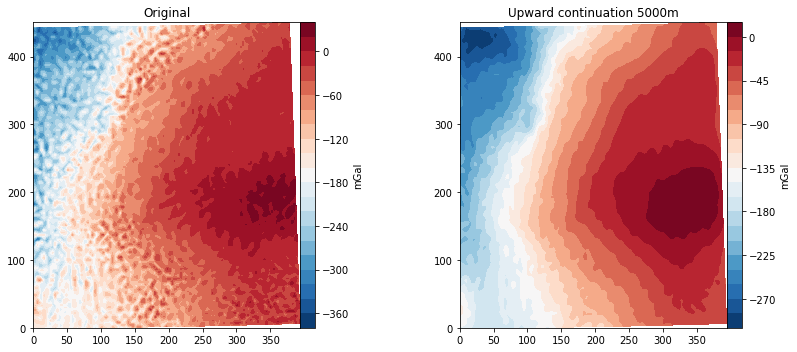

In [23]:
args = dict(shape=shape, levels=20, cmap=plt.cm.RdBu_r)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.ravel() 
plt.sca(axes[0])
plt.title("Original") 
plt.axis('scaled') 
giplt.contourf(X, Y, gravity_origin, **args) 
plt.colorbar(pad=0).set_label('mGal') 
giplt.m2km() 
plt.sca(axes[1]) 
plt.title('Upward continuation 5000m') 
plt.axis('scaled') 
giplt.contourf(X, Y, bgas_contf , **args) 
plt.colorbar(pad=0).set_label('mGal') 
giplt.m2km() 
fig.tight_layout()

向上延拓5000m后，异常是不是变光滑了！其实延拓也起到了一种滤波效果。

### 重力数据空间导数求取
空间导数的计算与延拓类似，都在pftrans模块下，函数名称为：derivx，derivy，derivz。分别对应三个方向。参数多了一个order，可以设置求取不同阶数。另外，还有一个函数tga，这个可以用于求位场的解析信号。

In [24]:
bgas_dx = pftrans.derivx(X, Y, bgas_contf, shape) 
bgas_dy = pftrans.derivy(X, Y, bgas_contf, shape) 
bgas_dz = pftrans.derivz(X, Y, bgas_contf, shape) 
bgas_tga = pftrans.tga(X, Y, bgas_contf, shape) 

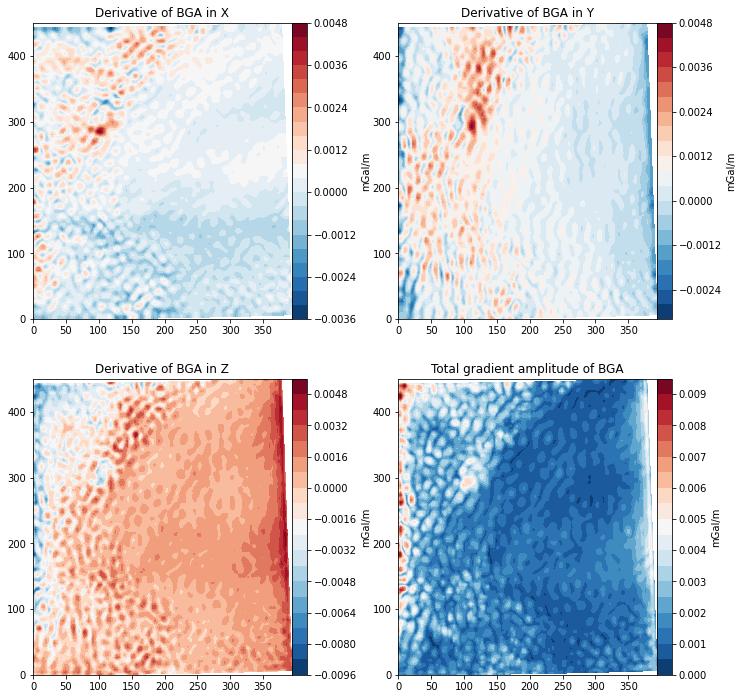

In [25]:
bgas_dx = pftrans.derivx(X, Y, bgas_contf, shape) 
bgas_dy = pftrans.derivy(X, Y, bgas_contf, shape) 
bgas_dz = pftrans.derivz(X, Y, bgas_contf, shape) 
bgas_tga = pftrans.tga(X, Y, bgas_contf, shape) 
args = dict(shape=shape, levels=20, cmap=plt.cm.RdBu_r) 
fig, axes = plt.subplots(2, 2, figsize=(12, 12)) 
plt.sca(axes[0, 0]) 
plt.title("Derivative of BGA in X") 
plt.axis('scaled') 
giplt.contourf(X, Y, bgas_dx, **args) 
plt.colorbar(pad=0).set_label('mGal/m') 
giplt.m2km()
plt.sca(axes[0, 1]) 
plt.title("Derivative of BGA in Y") 
plt.axis('scaled') 
giplt.contourf(X, Y, bgas_dy, **args) 
plt.colorbar(pad=0).set_label('mGal/m') 
giplt.m2km() 
plt.sca(axes[1, 0]) 
plt.title("Derivative of BGA in Z") 
plt.axis('scaled') 
giplt.contourf(X, Y, bgas_dz, **args) 
plt.colorbar(pad=0).set_label('mGal/m') 
giplt.m2km() 
plt.sca(axes[1, 1]) 
plt.title("Total gradient amplitude of BGA") 
plt.axis('scaled')
giplt.contourf(X, Y, bgas_tga, **args) 
plt.colorbar(pad=0).set_label('mGal/m') 
giplt.m2km()